In [1]:
# import the libraries
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16


In [2]:
# Downloading the flowers dataset
(training_set, test_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:75%]', 'train[:25%]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
# Number of classes in dataset
num_classes = dataset_info.features['label'].num_classes
num_classes

5

In [4]:
# Check the total number of images for train and test
num_training_examples = 0
num_test_examples = 0
for example in training_set:
    num_training_examples += 1
for example in test_set:
    num_test_examples += 1
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Test Images: {} \n'.format(num_test_examples))

Total Number of Classes: 5
Total Number of Training Images: 2752
Total Number of Test Images: 918 



In [5]:
# Check the shape of images 
for i, example in enumerate(training_set.take(5)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


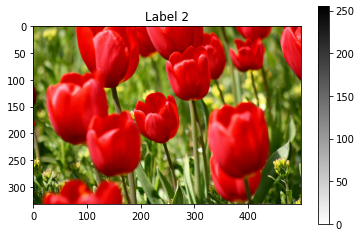

In [6]:
# visualising the data
for image, label in training_set.take(1):
    break
image = image.numpy()
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.title('Label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.show()

In [7]:
# Resizing the images into 150*150 
IMAGE_RES = 150
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label
BATCH_SIZE = 32
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_set.map(format_image).batch(BATCH_SIZE).prefetch(1)
print(train_batches)
print(test_batches)

<PrefetchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int64)>


In [8]:
# Loading VGG16 model and removed the top layers(fully connected layers)
base_model1 = VGG16(weights="imagenet", include_top=False, input_shape=(150,150,3))
base_model1.trainable = False 


58900480/58889256 [==============================] - 1s 0us/step


In [9]:
# Checking the layers of model (all layers are freeze)
for i, layer in enumerate(base_model1.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [10]:
base_model1.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [11]:
# Adding the fully connected layers (one with 256 nodes using ‘relu’ activation and output layer with 5 nodes and ‘softmax’activation)
from tensorflow.keras import layers, models
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(256, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')
model1 = models.Sequential([
    base_model1,
    flatten_layer,
    dense_layer_1,
    prediction_layer
])

In [12]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 2,098,693
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
# Compiling the model 
model1.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [14]:
# Training the model
EPOCHS = 10
history = model1.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=test_batches
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


86/86 [==============================] - 54s 230ms/step - loss: 0.9486 - accuracy: 0.6664 - val_loss: 0.5028 - val_accuracy: 0.8322
Epoch 2/10
86/86 [==============================] - 16s 186ms/step - loss: 0.4848 - accuracy: 0.8238 - val_loss: 0.2767 - val_accuracy: 0.9194
Epoch 3/10
86/86 [==============================] - 16s 187ms/step - loss: 0.2755 - accuracy: 0.9124 - val_loss: 0.2050 - val_accuracy: 0.9466
Epoch 4/10
86/86 [==============================] - 16s 188ms/step - loss: 0.1693 - accuracy: 0.9560 - val_loss: 0.0918 - val_accuracy: 0.9902
Epoch 5/10
86/86 [==============================] - 16s 188ms/step - loss: 0.0948 - accuracy: 0.9833 - val_loss: 0.0618 - val_accuracy: 0.9935
Epoch 6/10
86/86 [==============================] - 16s 188ms/step - loss: 0.0607 - accuracy: 0.9927 - val_loss: 0.0370 - val_accuracy: 1.0000
Epoch 7/10
86/86 [==============================] - 16s 188ms/step - loss: 0.0377 - accuracy: 0.9978 - val_loss: 0.0263 - val_accuracy: 1.0000
Epoch 8/10

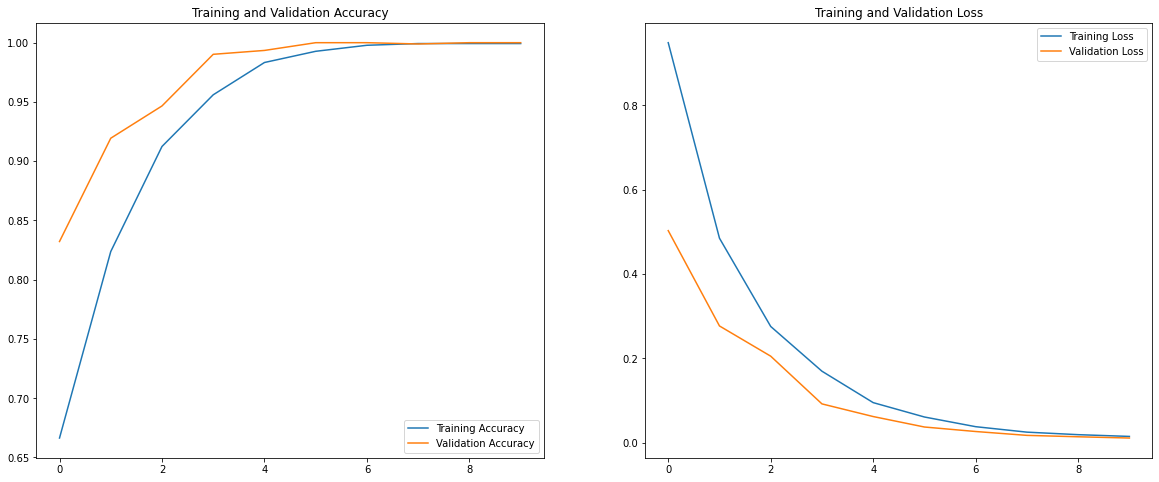

In [15]:
# Plotting the graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
# getting the classes names
class_names = np.array(dataset_info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [17]:
# Evaluating the model
model1.evaluate(test_batches)

29/29 [==============================] - 4s 139ms/step - loss: 0.0108 - accuracy: 1.0000


[0.010813643224537373, 1.0]

In [18]:
# Getting the predicted labels
image_batch, label_batch = next(iter(test_batches))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()
predicted_batch = model1.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

['tulips' 'sunflowers' 'sunflowers' 'roses' 'sunflowers' 'dandelion'
 'dandelion' 'dandelion' 'dandelion' 'daisy' 'sunflowers' 'tulips' 'roses'
 'daisy' 'tulips' 'daisy' 'tulips' 'roses' 'tulips' 'tulips' 'dandelion'
 'dandelion' 'dandelion' 'tulips' 'dandelion' 'sunflowers' 'dandelion'
 'daisy' 'daisy' 'daisy' 'tulips' 'daisy']


In [19]:
# printing the original and predicted labels
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [2 3 3 4 3 0 0 0 0 1 3 2 4 1 2 1 2 4 2 2 0 0 0 2 0 3 0 1 1 1 2 1]
Predicted labels:  [2 3 3 4 3 0 0 0 0 1 3 2 4 1 2 1 2 4 2 2 0 0 0 2 0 3 0 1 1 1 2 1]


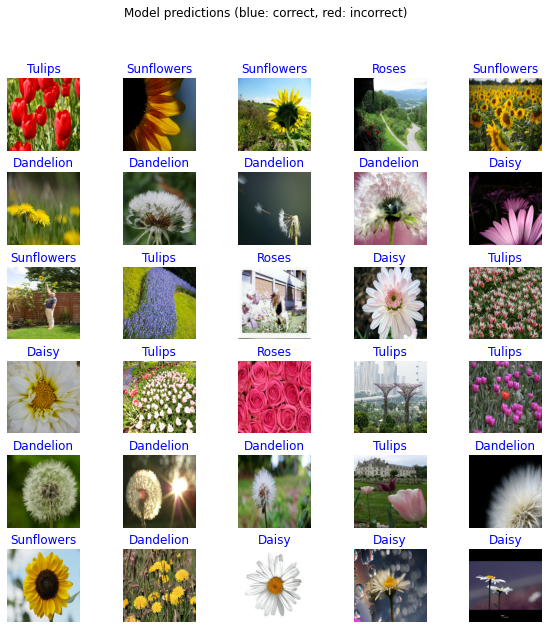

In [20]:
# visuzlizng the results
plt.figure(figsize=(10,10))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

The accuracy of this model is almost 100 percent. This is due to do the use of pretrained weights of imagenet model. 

In [21]:
# Loading VGG16 model and removed the top layers(fully connected layers)
base_model2 = VGG16(weights="imagenet", include_top=False, input_shape=(150,150,3))
base_model2.trainable = True 
for layer in base_model2.layers[:15]:
    layer.trainable = False

In [22]:
# Checking the layers of model (unfreeze the last block of VGG16 (block5))
for i, layer in enumerate(base_model2.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [23]:
base_model2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [24]:
# Adding the fully connected layers (one with 256 nodes using ‘relu’ activation and output layer with 5 nodes and ‘softmax’activation)
from tensorflow.keras import layers, models
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(256, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')
model2 = models.Sequential([
    base_model2,
    flatten_layer,
    dense_layer_1,
    prediction_layer
])

In [25]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 9,178,117
Non-trainable params: 7,635,264
_________________________________________________________________


In [26]:
# Compiling the model
model2.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [27]:
# Training the model
EPOCHS = 10
history = model2.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=test_batches
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


86/86 [==============================] - 21s 217ms/step - loss: 1.7443 - accuracy: 0.2373 - val_loss: 1.6017 - val_accuracy: 0.2582
Epoch 2/10
86/86 [==============================] - 18s 212ms/step - loss: 1.6025 - accuracy: 0.2485 - val_loss: 1.5993 - val_accuracy: 0.2582
Epoch 3/10
86/86 [==============================] - 18s 213ms/step - loss: 1.6016 - accuracy: 0.2485 - val_loss: 1.5989 - val_accuracy: 0.2582
Epoch 4/10
86/86 [==============================] - 18s 212ms/step - loss: 1.6014 - accuracy: 0.2485 - val_loss: 1.5989 - val_accuracy: 0.2582
Epoch 5/10
86/86 [==============================] - 18s 213ms/step - loss: 1.6014 - accuracy: 0.2485 - val_loss: 1.5990 - val_accuracy: 0.2582
Epoch 6/10
86/86 [==============================] - 18s 211ms/step - loss: 1.6013 - accuracy: 0.2485 - val_loss: 1.5989 - val_accuracy: 0.2582
Epoch 7/10
86/86 [==============================] - 18s 213ms/step - loss: 1.6016 - accuracy: 0.2485 - val_loss: 1.5987 - val_accuracy: 0.2582
Epoch 8/10

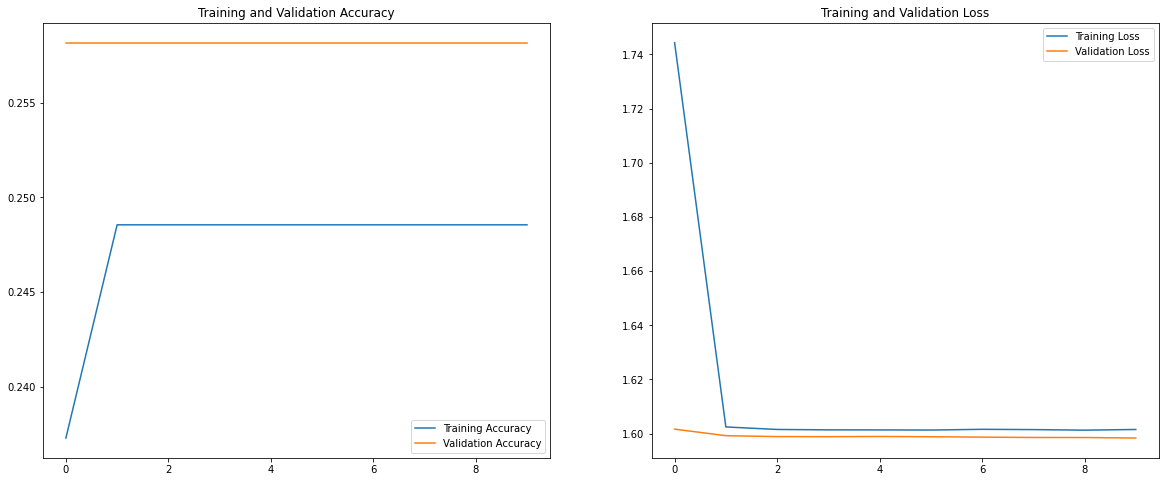

In [28]:
# Plotting the graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
# getting the classes names
class_names = np.array(dataset_info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [30]:
# Evaluating the model
model2.evaluate(test_batches)

29/29 [==============================] - 4s 140ms/step - loss: 1.5984 - accuracy: 0.2582


[1.5983974933624268, 0.258169949054718]

In [31]:
# Getting the predicted labels
image_batch, label_batch = next(iter(test_batches))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()
predicted_batch = model2.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

['dandelion' 'dandelion' 'dandelion' 'dandelion' 'dandelion' 'dandelion'
 'dandelion' 'dandelion' 'dandelion' 'dandelion' 'dandelion' 'dandelion'
 'dandelion' 'dandelion' 'dandelion' 'dandelion' 'dandelion' 'dandelion'
 'dandelion' 'dandelion' 'dandelion' 'dandelion' 'dandelion' 'dandelion'
 'dandelion' 'dandelion' 'dandelion' 'dandelion' 'dandelion' 'dandelion'
 'dandelion' 'dandelion']


In [32]:
# printing the original and predicted labels
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [2 3 3 4 3 0 0 0 0 1 3 2 4 1 2 1 2 4 2 2 0 0 0 2 0 3 0 1 1 1 2 1]
Predicted labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


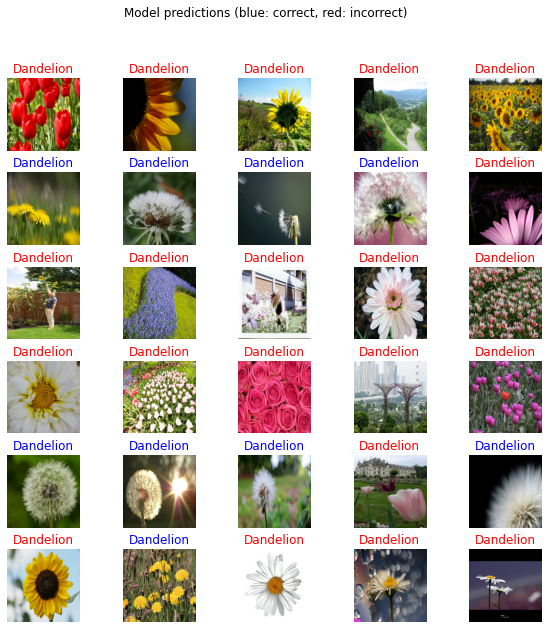

In [33]:
# visuzlizng the results
plt.figure(figsize=(10,10))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

The accuracy of this model is around 25 percent and its not good because we are retraining the block only not the all blocks of the model.

In [34]:
# Loading VGG16 model and removed the top layers(fully connected layers)
base_model3 = VGG16(weights="imagenet", include_top=False, input_shape=(150,150,3))
base_model3.trainable = True

In [35]:
# Checking the layers of model (Unfreeze all the layers)
for i, layer in enumerate(base_model3.layers):
    print(i, layer.name, layer.trainable)

0 input_3 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [36]:
# Adding the fully connected layers (one with 256 nodes using ‘relu’ activation and output layer with 5 nodes and ‘softmax’activation)
from tensorflow.keras import layers, models
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(256, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')
model3 = models.Sequential([
    base_model3,
    flatten_layer,
    dense_layer_1,
    prediction_layer
])

In [37]:
# Compiling the model
model3.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [38]:
# Training the model
EPOCHS = 10
history = model3.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=test_batches
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


86/86 [==============================] - 44s 467ms/step - loss: 1.7103 - accuracy: 0.3190 - val_loss: 1.2683 - val_accuracy: 0.4542
Epoch 2/10
86/86 [==============================] - 40s 464ms/step - loss: 1.2978 - accuracy: 0.4560 - val_loss: 1.0785 - val_accuracy: 0.5599
Epoch 3/10
86/86 [==============================] - 40s 465ms/step - loss: 1.1757 - accuracy: 0.5185 - val_loss: 1.0046 - val_accuracy: 0.5959
Epoch 4/10
86/86 [==============================] - 40s 464ms/step - loss: 1.1018 - accuracy: 0.5454 - val_loss: 0.9809 - val_accuracy: 0.6111
Epoch 5/10
86/86 [==============================] - 40s 464ms/step - loss: 1.0711 - accuracy: 0.5516 - val_loss: 0.9566 - val_accuracy: 0.6176
Epoch 6/10
86/86 [==============================] - 40s 464ms/step - loss: 0.9860 - accuracy: 0.6010 - val_loss: 0.8506 - val_accuracy: 0.6438
Epoch 7/10
86/86 [==============================] - 40s 464ms/step - loss: 0.9410 - accuracy: 0.6359 - val_loss: 0.8662 - val_accuracy: 0.6721
Epoch 8/10

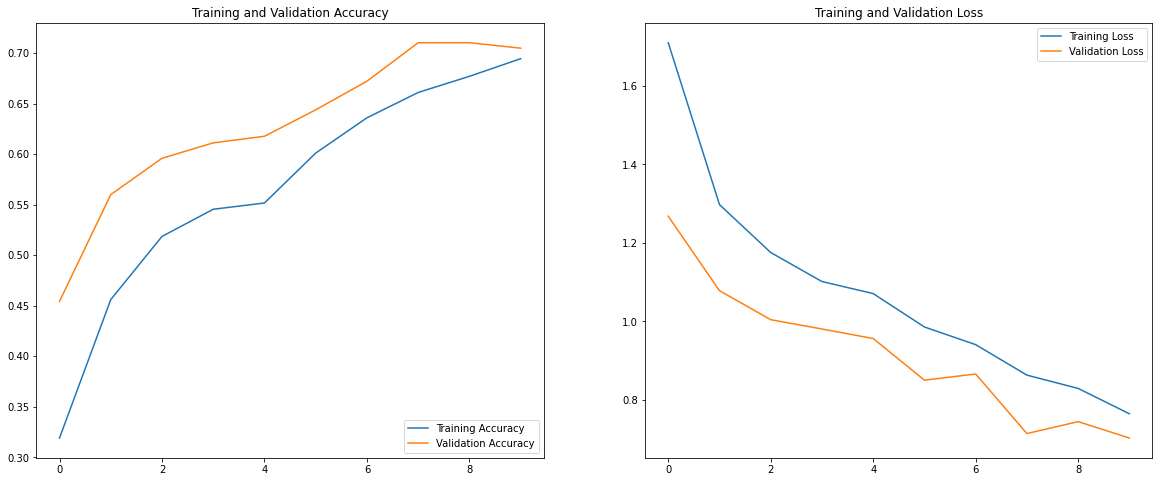

In [39]:
# Plotting the graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
# getting the classes names
class_names = np.array(dataset_info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [41]:
# Evaluating the model
model3.evaluate(test_batches)

29/29 [==============================] - 4s 136ms/step - loss: 0.7031 - accuracy: 0.7048


[0.7031063437461853, 0.7047930359840393]

In [42]:
# Getting the predicted labels
image_batch, label_batch = next(iter(test_batches))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()
predicted_batch = model3.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

['tulips' 'sunflowers' 'sunflowers' 'tulips' 'sunflowers' 'dandelion'
 'dandelion' 'dandelion' 'dandelion' 'roses' 'tulips' 'sunflowers' 'roses'
 'roses' 'tulips' 'sunflowers' 'tulips' 'roses' 'roses' 'tulips'
 'dandelion' 'dandelion' 'dandelion' 'tulips' 'dandelion' 'sunflowers'
 'sunflowers' 'daisy' 'daisy' 'daisy' 'tulips' 'roses']


In [43]:
# printing the original and predicted labels
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [2 3 3 4 3 0 0 0 0 1 3 2 4 1 2 1 2 4 2 2 0 0 0 2 0 3 0 1 1 1 2 1]
Predicted labels:  [2 3 3 2 3 0 0 0 0 4 2 3 4 4 2 3 2 4 4 2 0 0 0 2 0 3 3 1 1 1 2 4]


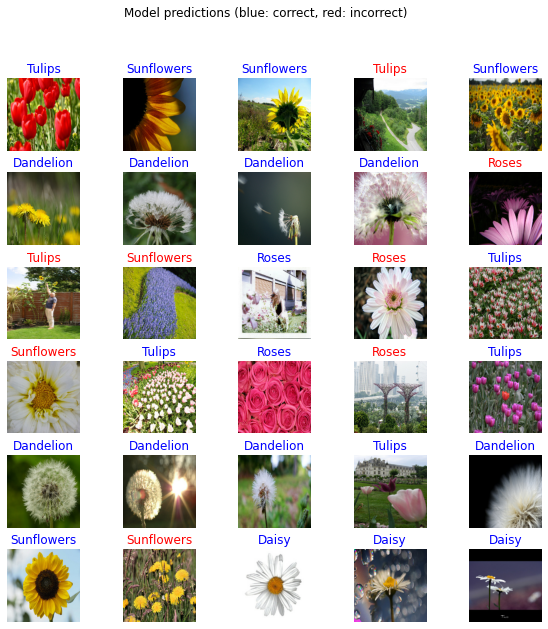

In [44]:
# visuzlizng the results
plt.figure(figsize=(10,10))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

The accuracy of this model is 68 percent which is better than model 2 because aall the blocks are retrained but not better then 1st model because that model only fine tunning the fully connected layers.